In [4]:
import numpy as np
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf

% matplotlib inline

Ex1: Build a classifier for MNIST that achieves over 97% accuracy on the test set

Prob analysis:
1. This ia a multiclass classification problem, we could let sklearn automatically detect what type of classifier to use (Onevsone or OnevsAll) based on datasize
2.  Accuracy  is defined  as the ratio between true positive/(true positive+false negative),we need to be able to set this value throug sklearn
3. What should a classifier include:
    1> Input is the input image(test set)
    2> Images will go through pre-processing
    3> Pre-possed image will go through classifier and get the category label
4.  So our step will be
    1> Set the data into training and testing set
    2> Preprocess the image with mean subtraction and normalization
    3>  Train the classifier with selected accuracy and k-folds cross validation

In [5]:
# Load MNIST dataset, process the data so that they have the right shape for seperating into training and testing set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
X = np.concatenate([mnist.train.images, mnist.test.images, mnist.validation.images])
y = np.concatenate([mnist.train.labels, mnist.test.labels, mnist.validation.labels])
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

In [7]:
# Remove mean from the image
def pre_pro(X_train):
    mean_x = np.mean(X_train, axis=0)
    X_demean = X_train - mean_x
    mean_x_demean = np.mean(X_demean, axis=0)
    # plt.imshow(mean_x_demean.reshape(28, 28), cmap='Greys')
    # Check norm of the digits by hand
    X_norm_1 = np.sqrt(np.diagonal(np.dot(X_demean.T, X_demean)))
    # Check norm of the digits with default function
    X_norm_2 = np.linalg.norm(X_demean ,ord=2, axis=0)
    # Make the image unit variance
    X_demean_scale = sklearn.preprocessing.normalize(X_demean, norm='l2', axis=1, copy=True, return_norm=False)
    return X_demean_scale

In [8]:
X_demean_scale = pre_pro(X_train)
X_test_scale = pre_pro(X_test)

In [9]:
# Build classfifier with data demeaned normalized data
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_demean_scale, y_train)
# sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
cross_val_score(sgd_clf, X_demean_scale, y_train, cv=3, scoring='accuracy')

array([ 0.90254676,  0.90110729,  0.90605565])

In [12]:
# Implement cross validation by hand
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, vali_index in skfolds.split(X_demean_scale, y_train):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_demean_scale[train_index]
        y_train_folds = y_train[train_index]
        X_vali_folds = X_demean_scale[vali_index]
        y_vali_folds = y_train[vali_index]
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_vali_folds)
        n_correct = sum(y_pred==y_vali_folds)
        print(n_correct/len(y_pred))

0.902546763375
0.90110729286
0.906055646481


From above implementation we could see that SGDclassfier is used to train a certain model with fixed train and target import . Therefore, what crossvalidation does is not for training a model, if for evaluating the model with the given training datasize.

In [13]:
# Let's check whether they use OnevsAll or OnevsOne algorithm
some_digit=X_test[10,:]
some_digit_scores= sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 26.65709322, -37.04897555,  -2.0333065 ,  -7.07632592,
        -18.90664656,  -9.34965481, -15.39746821, -28.05981157,
         11.28947143, -41.34297422]])

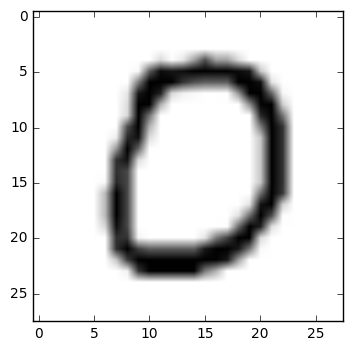

In [14]:
plt.imshow(some_digit.reshape(28, 28), cmap="Greys")

In [15]:
# Obtain test accuracy
y_pred_test = sgd_clf.predict(X_test_scale)
test_acc = sum(y_pred_test == y_test)/len(y_test)
test_acc

0.91049999999999998

In [16]:
# SVM based linear classifier may not be capable of doing the test, let's try KNeighbor classifier
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier()
kn_clf.fit(X_demean_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [17]:
# cross_val_score(kn_clf, X_demean_scale, y_train, cv=3, scoring="accuracy")

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [3,5,10], 'weights': ['uniform','distance']}
]

grid_search = GridSearchCV(kn_clf, param_grid, cv=3, scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(X_demean_scale, y_train)

In [ ]:
grid_search.best_params_